# Getting Started with TensorFlow!

This notebook shows how to get started with Quantus with `tensorflow`, using a very simple example. For this purpose, we use a LeNet model and MNIST dataset.

In [ ]:
from IPython.display import clear_output
!pip install quantus tensorflow tf-explain
!pip install matplotlib==3.1.3
#!pip install tensorflow==2.6.2 quantus tf-explain
clear_output()

In [ ]:
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.image import grayscale_to_rgb
import tf_explain
import matplotlib.pyplot as plt
import seaborn as sns
import quantus
sns.set()
clear_output()

## 1) Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [ ]:
# Load datasets
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

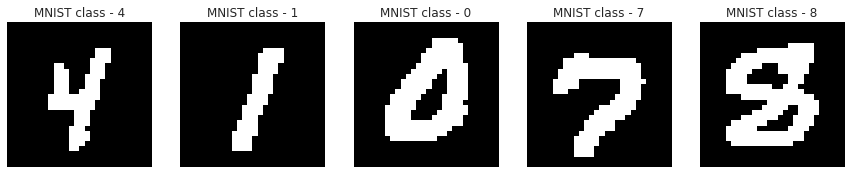

In [ ]:
# Plot some inputs!
i = 0
nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for x_batch, y_batch in ds_train.take(nr_images):
    axes[i].imshow((np.reshape(x_batch.numpy(), (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"MNIST class - {y_batch}")
    axes[i].axis("off")
    i += 1

plt.show()

### 1.2 Train a LeNet model

In [ ]:
def normalise_img(image, label) -> float:
  """Normalise images: `uint8` -> `float32`."""
  return tf.expand_dims(tf.cast(image, tf.float32), axis = 3) / 255., label

def to_rgb(image, label):
    return grayscale_to_rgb(image), label

In [ ]:
# Build a training pipeline.
ds_train = ds_train.map(
    normalise_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# Build an evaluation pipeline.
ds_test = ds_test.map(
    normalise_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# Get the batches of data.
x_batch, y_batch = next(iter(ds_test))
x_batch = x_batch.numpy() [:,:,:,0]
y_batch = y_batch.numpy() 

In [ ]:
# Specify the architecture.
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

# Compile the model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train!
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

print(f"\n Model architecture: {model.summary()}\n")

Epoch 1/6
469/469 [==============================] - 7s 5ms/step - loss: 0.3530 - sparse_categorical_accuracy: 0.9026 - val_loss: 0.1942 - val_sparse_categorical_accuracy: 0.9432
Epoch 2/6
469/469 [==============================] - 2s 3ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.9527 - val_loss: 0.1417 - val_sparse_categorical_accuracy: 0.9591
Epoch 3/6
469/469 [==============================] - 1s 3ms/step - loss: 0.1192 - sparse_categorical_accuracy: 0.9658 - val_loss: 0.1099 - val_sparse_categorical_accuracy: 0.9680
Epoch 4/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0928 - sparse_categorical_accuracy: 0.9726 - val_loss: 0.0975 - val_sparse_categorical_accuracy: 0.9704
Epoch 5/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0743 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.0894 - val_sparse_categorical_accuracy: 0.9737
Epoch 6/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0613 - sparse_categorical_accu

### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `tf-explain`.

In [ ]:
# Generate Integrated Gradients attributions of the first batch of the test set. 
a_batch_intgrad = ( np.array( list( map( lambda x, y: tf_explain.core.integrated_gradients.IntegratedGradients().explain( ([x], None), model, y, n_steps=10 ), x_batch, y_batch, ) ), dtype=float, ) / 255 )
a_batch_grad = ( np.array( list( map( lambda x, y: tf_explain.core.vanilla_gradients.VanillaGradients().explain( ([x], None), model, y), x_batch, y_batch, ) ), dtype=float, ) / 255 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Unsupported model architecture for VanillaGradients. The last two layers of the model should be: a layer which computes class scores with no activation, followed by an activation layer.
  This is separate from the ipykernel package so we can avoid doing imports until


Visualise attributions given model and pairs of input-output.

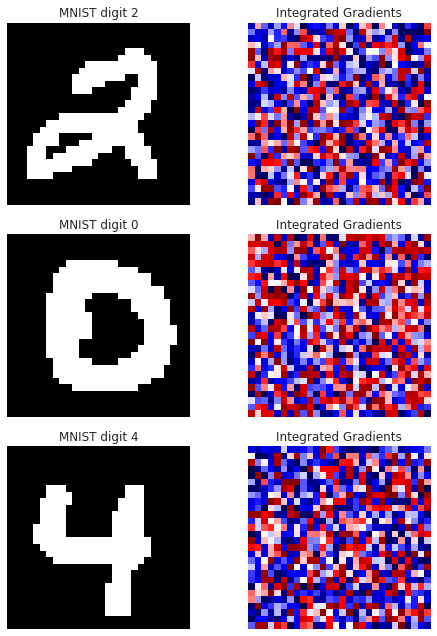

In [ ]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*2.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow((np.reshape(x_batch[i], (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i, 0].title.set_text(f"MNIST digit {y_batch[i].item()}")
    axes[i, 0].axis("off")
    a = axes[i, 1].imshow(a_batch_intgrad[i].reshape(28, 28), cmap="seismic")
    axes[i, 1].title.set_text(f"Integrated Gradients")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

## 2) Quantative evaluation using Quantus

We can evaluate our explanations on a variety of quantuative criteria but as a motivating example we test the Max-Sensitivity (Yeh at el., 2019) of the explanations. This metric tests how the explanations maximally change while subject to slight perturbations.

In [ ]:
# Define metric for evaluation.
metric_init = quantus.MaxSensitivity(nr_samples=10,
    lower_bound=0.1,
    norm_numerator=quantus.norm_func.fro_norm,
    norm_denominator=quantus.norm_func.fro_norm,
    perturb_func=quantus.perturb_func.uniform_noise,
    similarity_func=quantus.similarity_func.difference,
    disable_warnings=True,
    normalise=True,
    abs=True,)

In [ ]:
# Return Max-Sensitivity scores for Gradient.
scores_grad = metric_init(model=model, 
                            x_batch=x_batch,
                            y_batch=y_batch,
                            a_batch=None,
                            explain_func=quantus.explain,
                            explain_func_kwargs={"method": "Gradient"})

/usr/local/lib/python3.7/dist-packages/quantus/helpers/explanation_func.py:125: UserWarning: Unsupported model architecture for VanillaGradients. The last two layers of the model should be: a layer which computes class scores with no activation, followed by an activation layer.
  lambda x, y: explainer.explain(([x], None), model, y),


In [ ]:
# Return Max-Sensitivity scores for Integrated Gradients.
scores_intgrad = metric_init(model=model, 
                            x_batch=x_batch,
                            y_batch=y_batch,
                            a_batch=None,
                            explain_func=quantus.explain,
                            explain_func_kwargs={"method": "IntegratedGradients"})

In [ ]:
print(f"max-Sensitivity scores by Yeh et al., 2019\n" \
      f"\n • Gradient = {np.mean(scores_grad):.2f} ({np.std(scores_grad):.2f})." \
      f"\n • Integrated Gradients = {np.mean(scores_intgrad):.2f} ({np.std(scores_intgrad):.2f})."
      )

max-Sensitivity scores by Yeh et al., 2019

 • Gradient = 1.25 (0.31).
 • Integrated Gradients = 1.15 (0.31).
